# How to explicitly maximize the AUC

In this notebook I'm trying to optimize for the Area under ROC (AUC) explicitly, and not only during the hyperparameter tuning. In order to do this I'm introducing a new cost function that is based on Bradley-Terry-Luce model. For mathematical details please see [my Medium article](https://medium.com/@michaellarionov/explicit-auc-maximization-70beef6db14e) about it. We will use TensorFlow to take advantage of automatic differentiation. 

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
from sklearn.datasets import make_classification

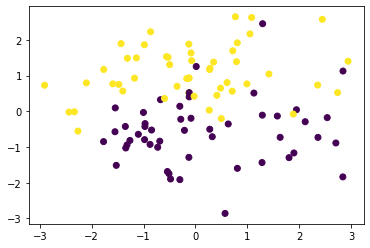

In [3]:
X, y = make_classification(100, 2, 2, 0, 0)
plt.scatter(X[:,0], X[:,1], c=y);

In [0]:
y = y.reshape(-1,1)

In [5]:
import tensorflow as tf
import keras.layers as L

Using TensorFlow backend.


In [0]:
learning_rate = 1.0
input_layer = L.Input((2,))
dense = L.Dense(units=1)
activations = dense(input_layer)
predictions = tf.sigmoid(activations)
# This is the new cost function.
cost = - tf.reduce_mean(tf.sigmoid(activations @ tf.transpose(activations)) * np.maximum(y @ np.ones(y.shape).T - np.ones(y.shape) @ y.T, 0))
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
training_op = optimizer.minimize(cost)


In [24]:
init = tf.global_variables_initializer()
n_epochs = 500

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
          print("Epoch", epoch, "Cost =", cost.eval(feed_dict={input_layer: X}))
        sess.run(training_op, feed_dict={input_layer: X})

    prediction_values = predictions.eval(feed_dict={input_layer: X}) 


Epoch 0 Cost = -0.12107406
Epoch 100 Cost = -0.24906836
Epoch 200 Cost = -0.2497198
Epoch 300 Cost = -0.24984348
Epoch 400 Cost = -0.24989356


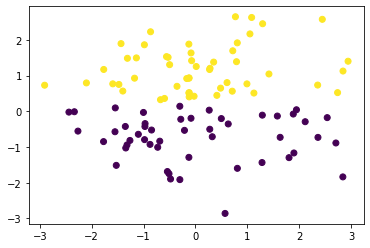

In [30]:
prediction_results = prediction_values.reshape((-1)) > 0.945
plt.scatter(X[:,0], X[:,1], c=prediction_results.reshape(-1));

## Discussion

The plot below is based on the threshold 0.945. If I were to choose the conventional threshold 0.5 we would get all observations in one class. Why is that? The reason is that AUC is not sensitive to the bias value. Indeed, since in this model we subtracting pairwise activations, the bias value cancels out. We can add additional term to the cost function to bring the bias closer to 0.5. Or choose to do  what we have done above, by hand-picking the threshold that works for us. I want to remind you, that we are optimizing for AUC, so if all observations are predicted to fall into a single class, it is cool with us as long as the AUC has the optimal value.
